# URL clustering based on similarity

- urls_df = full dataset
- urls_tdf = full dataset transformed
- urls_tsdf = sampled dataset transformed

## Imports & Helper functions

### Save or load jupyter session

### Imports

In [94]:
import random
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sp
import seaborn as sns
import smaz
import tldextract
from sklearn.cluster import Birch
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import (
    HashingVectorizer,
    TfidfTransformer,
    TfidfVectorizer,
)
from sklearn.metrics import (
    calinski_harabasz_score,
    davies_bouldin_score,
    silhouette_score,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, OneHotEncoder, StandardScaler

warnings.filterwarnings("ignore")

sns.set()

### Helper functions

In [2]:
from polyleven import levenshtein


def levenshtein_pdist(u, v):
    if isinstance(u, np.ndarray):
        u = u[0]
    if isinstance(v, np.ndarray):
        v = v[0]
    return levenshtein(u, v)

## Preprocessing

In [3]:
urls_df = pd.read_csv(
    "datasets/kaggle_siddharta_malicious_benign.csv",
    delimiter=",",
    dtype={"url": "string"},
)

urls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  string
 1   type    651191 non-null  object
dtypes: object(1), string(1)
memory usage: 9.9+ MB


### Extract domain names from URLs

In [4]:
# Regex pattern to extract fully qualified domain name (FQDN)
pattern = r"(?:.*?:\/\/)?(?P<www>[wW]{3}\.)?(?P<domain>[\w\.\-]+)[^\w]*"

# Execute regex over URLs
match = urls_df["url"].str.extract(pattern)

# Extract domain using named group
urls_df["FQDN"] = match["domain"]

# Indicate if www subdomain is present
urls_df["has_www"] = match["www"].notna()

urls_df.head()

,url,type,FQDN,has_www
0,br-icloud.com.br,phishing,br-icloud.com.br,False
1,mp3raid.com/music/krizz_kaliko.html,benign,mp3raid.com,False
2,bopsecrets.org/rexroth/cr/1.htm,benign,bopsecrets.org,False
3,http://www.garage-pirenne.be/index.php?option=...,defacement,garage-pirenne.be,True
4,http://adventure-nicaragua.net/index.php?optio...,defacement,adventure-nicaragua.net,False


### Remove all addreses without domain (IPs)

In [5]:
# Pattern that matches all IPv4 addresses
pattern = "(?:.*?:\/\/)?(?P<www>[wW]{3}\.)?[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}([/:].*)?$"

# Leave only data not containing pure IPv4
urls_df = urls_df[~urls_df["url"].str.match(pattern)]

# Reset index
urls_df = urls_df.reset_index(drop=True)

### Extract features from domains

#### Separate TLD, domain and subdomain

In [6]:
# Function to extract components of domain using tldextract
def extract_domain_components(url):
    ext = tldextract.extract(url)
    return pd.Series([ext.subdomain, ext.domain, ext.suffix, ext.suffix == ""])

In [7]:
# Apply function to url column to extract domain components and explode into separate columns
urls_df[["subdomain", "domain", "TLD", "is_invalid_TLD"]] = urls_df["url"].apply(
    extract_domain_components
)

In [8]:
urls_df[urls_df["is_invalid_TLD"]].head()

,url,type,FQDN,has_www,subdomain,domain,TLD,is_invalid_TLD
543171,www.udc.an/wp-includes/js/tinymce/themes/advan...,benign,udc.an,True,www.udc,an,,True
543545,www.udc.an/wp-includes/js/tinymce/themes/advan...,benign,udc.an,True,www.udc,an,,True
543670,772050312/www1.royalbank.com/cgi-bin/rbaccess/...,benign,772050312,False,,772050312,,True
555067,bin/webscr?cmd=_login-,benign,bin,False,,bin,,True
561288,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË Ó6(...,phishing,www,False,,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû,,True


In [9]:
# Remove domains with invalid TLD
urls_df = urls_df[~urls_df["is_invalid_TLD"]]

# Reset index
urls_df = urls_df.reset_index(drop=True)

#### Length of domain, subdomain and TLD

In [10]:
urls_df[["domain_length", "subdomain_length", "TLD_length"]] = urls_df[
    ["domain", "subdomain", "TLD"]
].applymap(len)
urls_df.head(2)

,url,type,FQDN,has_www,subdomain,domain,TLD,is_invalid_TLD,domain_length,subdomain_length,TLD_length
0,br-icloud.com.br,phishing,br-icloud.com.br,False,,br-icloud,com.br,False,9,0,6
1,mp3raid.com/music/krizz_kaliko.html,benign,mp3raid.com,False,,mp3raid,com,False,7,0,3


#### Number of subdomains

I decide to include www in the count of subdomains. Might make performance-wise issues later. Reconsider if needed

In [11]:
urls_df["num_of_subdomains"] = (
    urls_df["subdomain"].str.split(".").apply(lambda x: len(x) if x != [""] else 0)
)
urls_df.head(2)

,url,type,FQDN,has_www,subdomain,domain,TLD,is_invalid_TLD,domain_length,subdomain_length,TLD_length,num_of_subdomains
0,br-icloud.com.br,phishing,br-icloud.com.br,False,,br-icloud,com.br,False,9,0,6,0
1,mp3raid.com/music/krizz_kaliko.html,benign,mp3raid.com,False,,mp3raid,com,False,7,0,3,0


#### Characters frequency & vowel-to-consonant ratio
Characters:
- alphabetical - "a-zA-Z"
- digits - "0-9"
- special - all except alphabetical, digits and dot

Can be changed based on the occurences of dots. It may be better to remove dots so this information is uncorrelated with num_of_substrings

Try the result with and without dots to analyze the difference

In [12]:
for column in ["domain", "subdomain", "TLD"]:
    # Vowel-to-consonant ratio
    vowel_counts = urls_df[column].str.count(r"[aeiouAEIOU]")
    consonant_counts = urls_df[column].str.count(r"[b-df-hj-np-tv-zB-DF-HJ-NP-TV-Z]")

    # Get alphabetical, numeric and special character counts for specific column
    numeric_counts = urls_df[column].str.count(r"[0-9]")
    special_counts = urls_df[column].str.count(r"[^A-Za-z0-9\s\.]")
    alpha_counts = vowel_counts + consonant_counts

    # Add them into DF
    urls_df[
        [
            f"{column}_alpha_count",
            f"{column}_numeric_count",
            f"{column}_special_count",
            f"{column}_vowel_consonant_ratio",
        ]
    ] = pd.Series(
        [alpha_counts, numeric_counts, special_counts, vowel_counts / consonant_counts]
    )

urls_df.head(2)

,url,type,FQDN,has_www,subdomain,domain,TLD,is_invalid_TLD,domain_length,subdomain_length,...,domain_special_count,domain_vowel_consonant_ratio,subdomain_alpha_count,subdomain_numeric_count,subdomain_special_count,subdomain_vowel_consonant_ratio,TLD_alpha_count,TLD_numeric_count,TLD_special_count,TLD_vowel_consonant_ratio
0,br-icloud.com.br,phishing,br-icloud.com.br,False,,br-icloud,com.br,False,9,0,...,1,0.6,0,0,0,NaN,5,0,0,0.25
1,mp3raid.com/music/krizz_kaliko.html,benign,mp3raid.com,False,,mp3raid,com,False,7,0,...,0,0.5,0,0,0,NaN,3,0,0,0.50


#### Complexity of domain and subdomain

Using compression algorithm (`smaz` python implementation) to approximate Kolmogorov complexity

In [13]:
urls_df[["domain_complexity", "subdomain_complexity"]] = urls_df[
    ["domain", "subdomain"]
].applymap(lambda s: len(smaz.compress(s)) / len(s) if s != "" else np.nan)

### Encode labels

In [14]:
# Create OneHotEncoded features from type


ohenc = OneHotEncoder(sparse_output=False)
type_ohenc = pd.DataFrame(
    ohenc.fit_transform(urls_df["type"].values.reshape(-1, 1)),
    columns=ohenc.categories_[0],
).astype(bool)

# URLs_transformed df
urls_tdf = pd.concat([urls_df, type_ohenc], axis=1)

In [15]:
urls_tdf["malicious"] = ~urls_tdf["benign"]
urls_tdf.head()

,url,type,FQDN,has_www,subdomain,domain,TLD,is_invalid_TLD,domain_length,subdomain_length,...,TLD_numeric_count,TLD_special_count,TLD_vowel_consonant_ratio,domain_complexity,subdomain_complexity,benign,defacement,malware,phishing,malicious
0,br-icloud.com.br,phishing,br-icloud.com.br,False,,br-icloud,com.br,False,9,0,...,0,0,0.25,0.777778,NaN,False,False,False,True,True
1,mp3raid.com/music/krizz_kaliko.html,benign,mp3raid.com,False,,mp3raid,com,False,7,0,...,0,0,0.50,0.857143,NaN,True,False,False,False,False
2,bopsecrets.org/rexroth/cr/1.htm,benign,bopsecrets.org,False,,bopsecrets,org,False,10,0,...,0,0,0.50,0.800000,NaN,True,False,False,False,False
3,http://www.garage-pirenne.be/index.php?option=...,defacement,garage-pirenne.be,True,www,garage-pirenne,be,False,14,3,...,0,0,1.00,0.714286,1.0,False,True,False,False,True
4,http://adventure-nicaragua.net/index.php?optio...,defacement,adventure-nicaragua.net,False,,adventure-nicaragua,net,False,19,0,...,0,0,0.50,0.684211,NaN,False,True,False,False,True


#### N-grams & TF-IDF

##### Version 1 - sklearn Vectorizer

In [16]:
NGRAM_RANGE = (3, 4)

In [17]:
class IncrementalTfidf:
    """
    A class to process text data in chunks and incrementally compute character-level TF-IDF values.

    Attributes:
    -----------
    hashing_vectorizer : HashingVectorizer
        Vectorizer that converts text data to a term-document matrix using the hashing trick
    tfidf_transformer : TfidfTransformer
        Transformer that computes TF-IDF values from the term-document matrix
    X_counts : scipy.sparse matrix
        Accumulated term-document matrix
    X_tfidf : scipy.sparse matrix
        Accumulated TF-IDF representation
    """

    def __init__(
        self, n_features=2**20
    ):  # Default value for n_features in HashingVectorizer
        """
        Initializes the IncrementalTfidf with a HashingVectorizer and TfidfTransformer.
        """
        self.hashing_vectorizer = HashingVectorizer(
            analyzer="char", token_pattern=None, n_features=n_features
        )
        self.tfidf_transformer = TfidfTransformer()
        self.X_counts = None
        self.X_tfidf = None

    def update_tf_counts(self, chunk):
        """
        Updates the term-document matrix with the new chunk of text data.

        Parameters:
        -----------
        chunk : pandas.Series or list of str
            New chunk of text data
        """
        # Transform the chunk of text data into a term-document matrix using the HashingVectorizer
        chunk_counts = self.hashing_vectorizer.transform(chunk)

        # If this is the first chunk, set the term-document matrix to the transformed chunk
        if self.X_counts is None:
            self.X_counts = chunk_counts
        else:
            # Otherwise, stack the transformed chunk to the existing term-document matrix
            self.X_counts = sp.vstack((self.X_counts, chunk_counts))

    def update_idf(self):
        """
        Updates the TfidfTransformer based on the current term-document matrix.
        """
        self.tfidf_transformer.fit(self.X_counts)

    def partial_fit(self, chunk):
        """
        Updates the term-document matrix and fits the TfidfTransformer with the new chunk of text data.

        Parameters:
        -----------
        chunk : pandas.Series or list of str
            New chunk of text data

        Returns:
        --------
        self : IncrementalTfidf
            The instance of the IncrementalTfidf
        """
        self.update_tf_counts(chunk)
        self.update_idf()
        return self

    def transform(self, chunk):
        """
        Transforms the given chunk of text data to a TF-IDF representation.

        Parameters:
        -----------
        chunk : pandas.Series or list of str
            Chunk of text data to be transformed

        Returns:
        --------
        chunk_tfidf : scipy.sparse matrix
            Transformed chunk in TF-IDF representation
        """
        chunk_counts = self.hashing_vectorizer.transform(chunk)
        chunk_tfidf = self.tfidf_transformer.transform(chunk_counts)
        return chunk_tfidf

    def partial_fit_transform(self, chunk):
        """
        Updates the term-document matrix, fits the TfidfTransformer, and transforms the given chunk of text data.

        Parameters:
        -----------
        chunk : pandas.Series or list of str
            New chunk of text data

        Returns:
        --------
        chunk_tfidf : scipy.sparse matrix
            Transformed chunk in TF-IDF representation
        """
        self.partial_fit(chunk)
        return self.transform(chunk)

    def compute_tfidf(self):
        """
        Retrieves the accumulated TF-IDF representation of the processed text data.

        Returns:
        --------
        X_tfidf : scipy.sparse matrix
            Accumulated TF-IDF representation
        """
        self.X_tfidf = self.tfidf_transformer.transform(self.X_counts)
        return self.X_tfidf

In [18]:
incremental_domain_tfidf = IncrementalTfidf()
incremental_subdomain_tfidf = IncrementalTfidf()

incremental_domain_tfidf.partial_fit(urls_df["domain"])
incremental_subdomain_tfidf.partial_fit(urls_df["subdomain"])

# Retrieve the accumulated TF-IDF representation
X_domain_tfidf = incremental_domain_tfidf.compute_tfidf()
X_subdomain_tfidf = incremental_subdomain_tfidf.compute_tfidf()

In [42]:
# Calculate the explained variance ratio for different numbers of components
max_n_components = 60  # Adjust based on your needs
explained_variance_ratios = []
times = []

for n_components in range(1, max_n_components + 1, 4):
    start = time.time()
    lsa = make_pipeline(TruncatedSVD(n_components=n_components), Normalizer(copy=False))
    lsa.fit_transform(X_domain_tfidf)
    explained_variance_ratio = lsa[0].explained_variance_ratio_.sum()
    explained_variance_ratios.append(explained_variance_ratio)
    end = time.time()
    times.append((n_components, end - start))

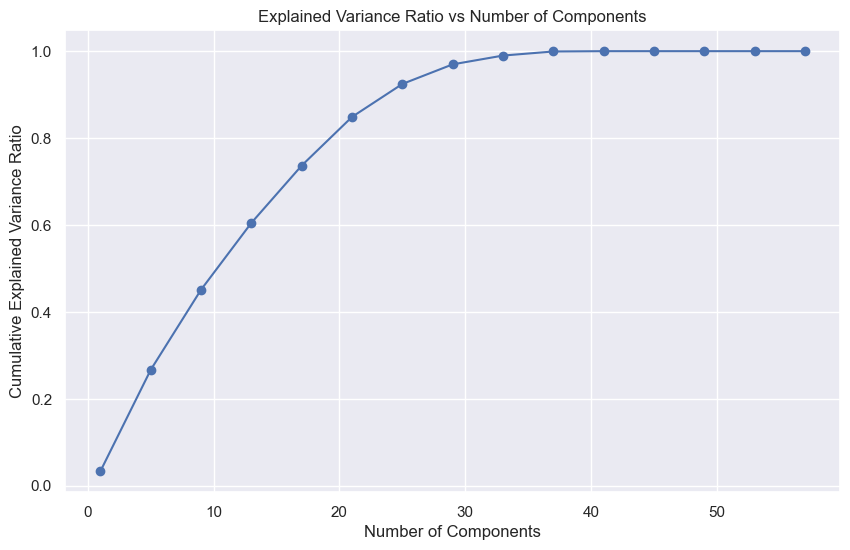

N_components and time in seconds [(1, 5.374884128570557), (5, 7.657818078994751), (9, 12.683306694030762), (13, 16.999669075012207), (17, 21.60098886489868), (21, 28.521011114120483), (25, 34.201815128326416), (29, 64.5866379737854), (33, 52.470755100250244), (37, 51.43163800239563), (41, 54.10720491409302), (45, 62.82287287712097), (49, 64.32070302963257), (53, 73.9494960308075), (57, 81.25824999809265)]


In [47]:
# Plot the cumulative explained variance ratio as a function of the number of components
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_n_components + 1, 4), explained_variance_ratios, marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.title("Explained Variance Ratio vs Number of Components")
plt.show()
print(f"N_components and time in seconds {times}")

In [48]:
# Calculate the explained variance ratio for different numbers of components
max_n_components_s = 60  # Adjust based on your needs
explained_variance_ratios_s = []
times_s = []

for n_components in range(1, max_n_components_s + 1, 4):
    start = time.time()
    lsa = make_pipeline(TruncatedSVD(n_components=n_components), Normalizer(copy=False))
    lsa.fit_transform(X_subdomain_tfidf)
    explained_variance_ratio = lsa[0].explained_variance_ratio_.sum()
    explained_variance_ratios_s.append(explained_variance_ratio)
    end = time.time()
    times_s.append((n_components, end - start))

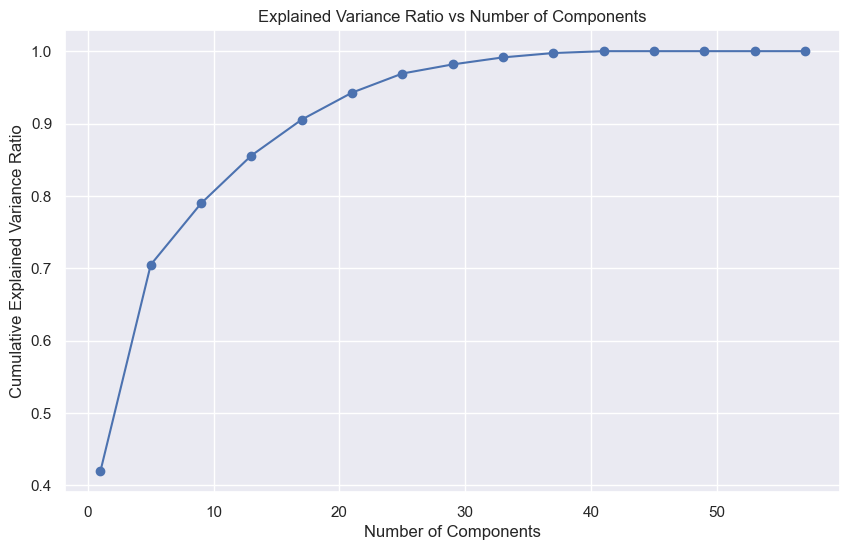

N_components and time in seconds [(1, 5.374884128570557), (5, 7.657818078994751), (9, 12.683306694030762), (13, 16.999669075012207), (17, 21.60098886489868), (21, 28.521011114120483), (25, 34.201815128326416), (29, 64.5866379737854), (33, 52.470755100250244), (37, 51.43163800239563), (41, 54.10720491409302), (45, 62.82287287712097), (49, 64.32070302963257), (53, 73.9494960308075), (57, 81.25824999809265)]


In [49]:
# Plot the cumulative explained variance ratio as a function of the number of components
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_n_components_s + 1, 4), explained_variance_ratios_s, marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.title("Explained Variance Ratio vs Number of Components")
plt.show()
print(f"N_components and time in seconds {times}")

In [19]:
urls_df_imputed = urls_df.copy()

# Replace NaN values with zeros
urls_df_imputed.fillna(0, inplace=True)

# Replace infinities with the maximum finite value in each column
urls_df_imputed = urls_df_imputed.replace([np.inf, -np.inf], np.nan)
max_values = urls_df_imputed.max()
urls_df_imputed.fillna(max_values, inplace=True)

In [95]:
ssc = StandardScaler()

urls_df_relevant_scaled = ssc.fit_transform(urls_df_imputed.iloc[:, 8:])

In [96]:
pca = PCA(n_components=0.95)
urls_df_relevant_selected = pca.fit_transform(urls_df_relevant_scaled)

urls_df_relevant_sparse = sp.csr_matrix(urls_df_relevant_selected)

In [97]:
# Taken from https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#performing-dimensionality-reduction-using-lsa

lsa_domain = make_pipeline(TruncatedSVD(n_components=37), Normalizer(copy=False))
lsa_subdomain = make_pipeline(TruncatedSVD(n_components=37), Normalizer(copy=False))

X_domain_lsa = lsa_domain.fit_transform(X_domain_tfidf)
explained_variance = lsa_domain[0].explained_variance_ratio_.sum()

X_subdomain_lsa = lsa_subdomain.fit_transform(X_subdomain_tfidf)
explained_variance = lsa_subdomain[0].explained_variance_ratio_.sum()


print(f"Explained variance of domain in the SVD step: {explained_variance * 100:.1f}%")
print(
    f"Explained variance of subdomain in the SVD step: {explained_variance * 100:.1f}%"
)

Explained variance of domain in the SVD step: 99.7%
Explained variance of subdomain in the SVD step: 99.7%


In [98]:
X = sp.hstack((urls_df_relevant_sparse, X_domain_lsa, X_subdomain_lsa), format="csr")

In [101]:
sample_size = 40000
data_size = X.shape[0]

indices = random.sample(range(data_size), sample_size)

X_subset = X[indices]

In [103]:
# Create a BIRCH clustering instance
birch_clustering = Birch(n_clusters=None)

# Fit the BIRCH clustering model on the TF-IDF data
birch_clustering.fit(X_subset)

# Get the cluster labels for each data point
labels = birch_clustering.labels_

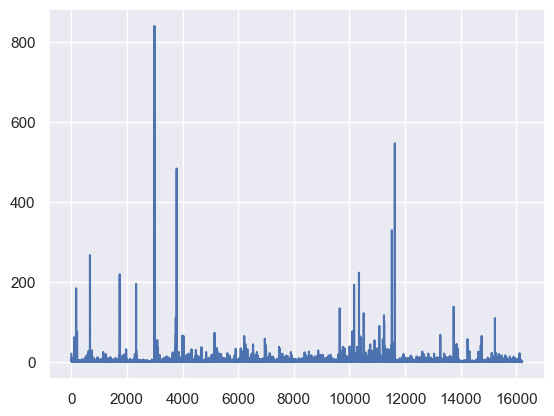

In [104]:
plt.plot(np.bincount(labels))

In [105]:
sample_size = 5000
data_size = X_subset.shape[0]

# Generate random indices
sample_indices = random.sample(range(data_size), sample_size)

# Slice the sparse matrix using the generated indices
X_sample_sparse = X_subset[sample_indices]
labels_sample = labels[sample_indices]

In [106]:
# Calculate Silhouette Score
sil_score = silhouette_score(X_sample_sparse, labels_sample)

# Calculate Calinski-Harabasz Index
X_sample_dense = X_sample_sparse.toarray()
ch_index = calinski_harabasz_score(X_sample_dense, labels_sample)

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(X_sample_dense, labels_sample)

# Print the scores
print("Silhouette Score:", sil_score)
print("Calinski-Harabasz Index:", ch_index)
print("Davies-Bouldin Index:", db_index)

Silhouette Score: 0.3714598392780462
Calinski-Harabasz Index: 531.2487680337874
Davies-Bouldin Index: 0.3510776700047736


In [107]:
len([node for node in birch_clustering.subcluster_centers_])

16219

## Data exploration

### Levenshtein distances

#### Domain unchanged

In [108]:
# Create two sets of N_SAMPLES random samples
N_SAMPLES = 50000

urls_tsdf = pd.DataFrame()

urls_tsdf["sample1"] = urls_tdf.sample(n=N_SAMPLES, random_state=123).reset_index(
    drop=True
)["domain"]
urls_tsdf["sample2"] = urls_tdf.sample(n=N_SAMPLES, random_state=545).reset_index(
    drop=True
)["domain"]

In [109]:
# Calculate Levenshtein distance on each pair (N_SAMPLES distances)
urls_tsdf["levenshtein_distance_domain"] = urls_tsdf.apply(
    lambda row: levenshtein(row.sample1, row.sample2), axis=1
)

In [110]:
urls_tsdf.describe()

,levenshtein_distance_domain
count,50000.000000
mean,10.818640
std,4.225786
min,0.000000
25%,8.000000
50%,10.000000
75%,13.000000
max,59.000000


In [111]:
urls_tsdf

,sample1,sample2,levenshtein_distance_domain
0,pastehtml,m-runescape,10
1,niobestudio,profilecanada,11
2,yellowpages,hellomacon,6
3,eca,hockey-reference,14
4,funtrivia,cookpad,9
...,...,...,...
49995,9779,at,4
49996,9779,hrblockreferafriend,19
49997,matjand,bhsu,7
49998,locateaflowershop,muscle-xpo,14


Text(0.5, 1.0, "Distribution of levenshtein's distances among domains over 50000 random samples")

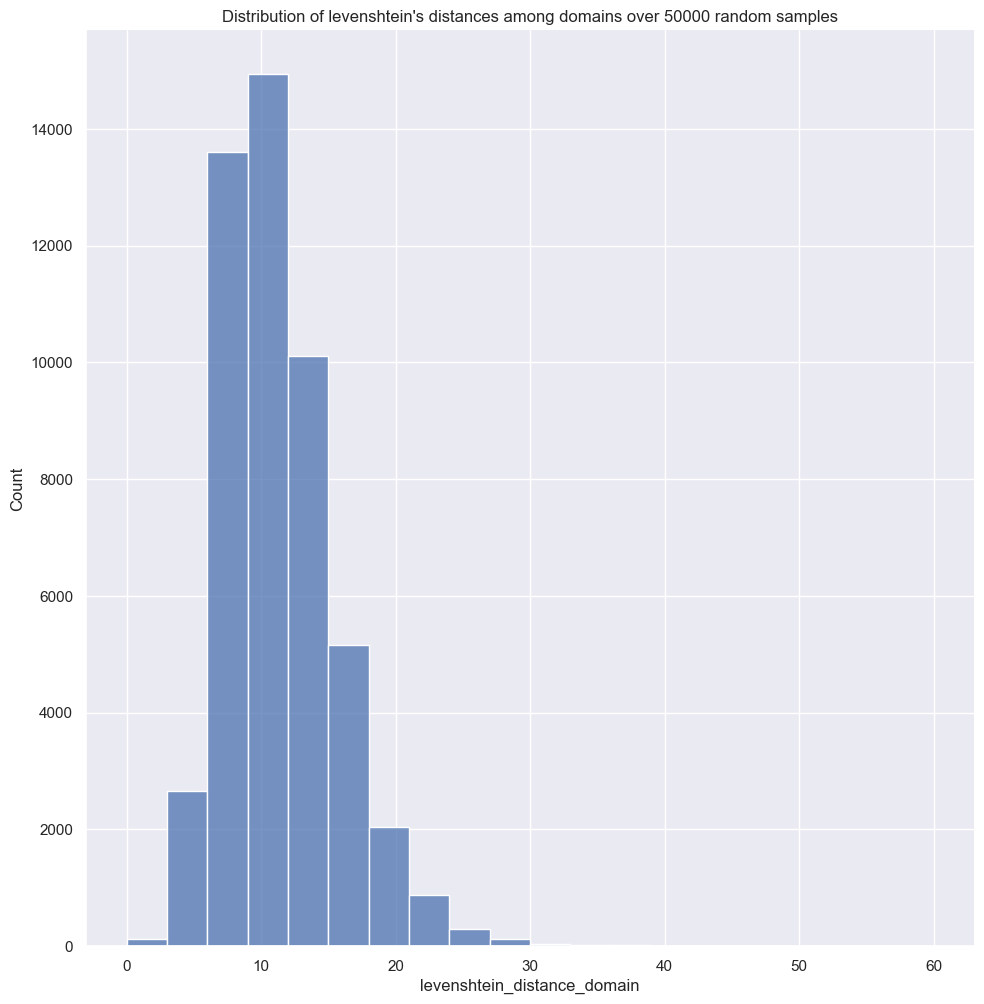

In [112]:
sns.displot(
    urls_tsdf,
    x="levenshtein_distance_domain",
    binwidth=3,
    height=10,
)
plt.title(
    f"Distribution of levenshtein's distances among domains over {N_SAMPLES} random samples"
)

Text(0.5, 1.0, "Distribution of levenshtein's distances among domains over 50000 random samples")

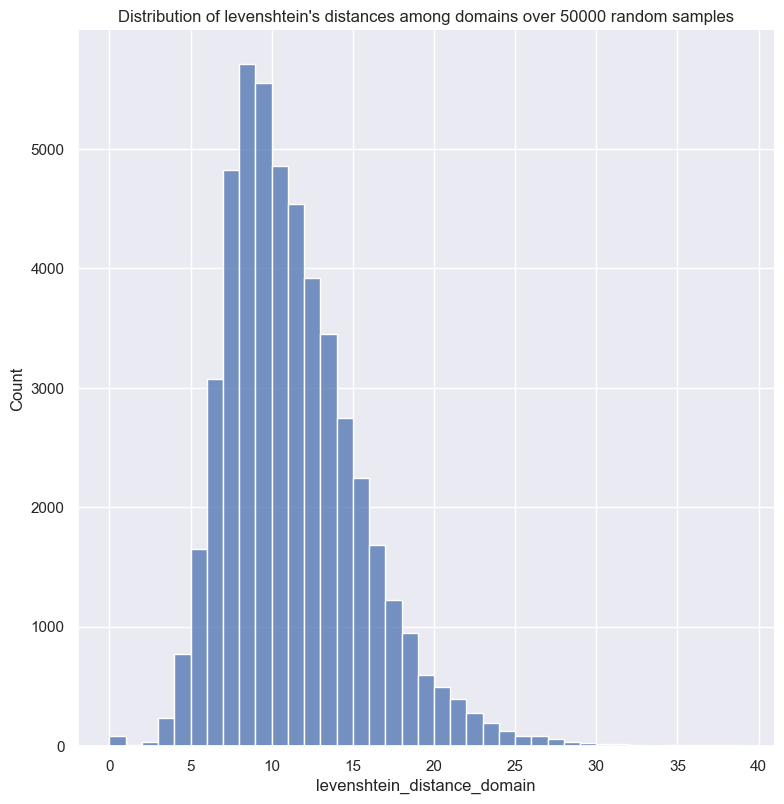

In [113]:
sns.displot(
    urls_tsdf[urls_tsdf["levenshtein_distance_domain"] < 40],
    x="levenshtein_distance_domain",
    binwidth=1,
    height=8,
)
plt.title(
    f"Distribution of levenshtein's distances among domains over {N_SAMPLES} random samples"
)

## Experiments

### Unchanged URLs

Keep `urls_tdf` intact for this section to show what it should

#### DBSCAN

DBSCAN will not work. It needs $\mathcal{O}(n^2)$

#### Hierarchical clustering

In [114]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

In [115]:
# Create two sets of N_SAMPLES random samples
N_SAMPLES = 1000

urls_tsdf = urls_tdf.sample(n=N_SAMPLES, random_state=111).reset_index(drop=True)

In [116]:
# Calculate pairwise distances between domains using levenshtein distance function
X = urls_tsdf["domain"].values.reshape(-1, 1)
distances = pdist(X, metric=levenshtein_pdist)
distances_squareform = squareform(distances)

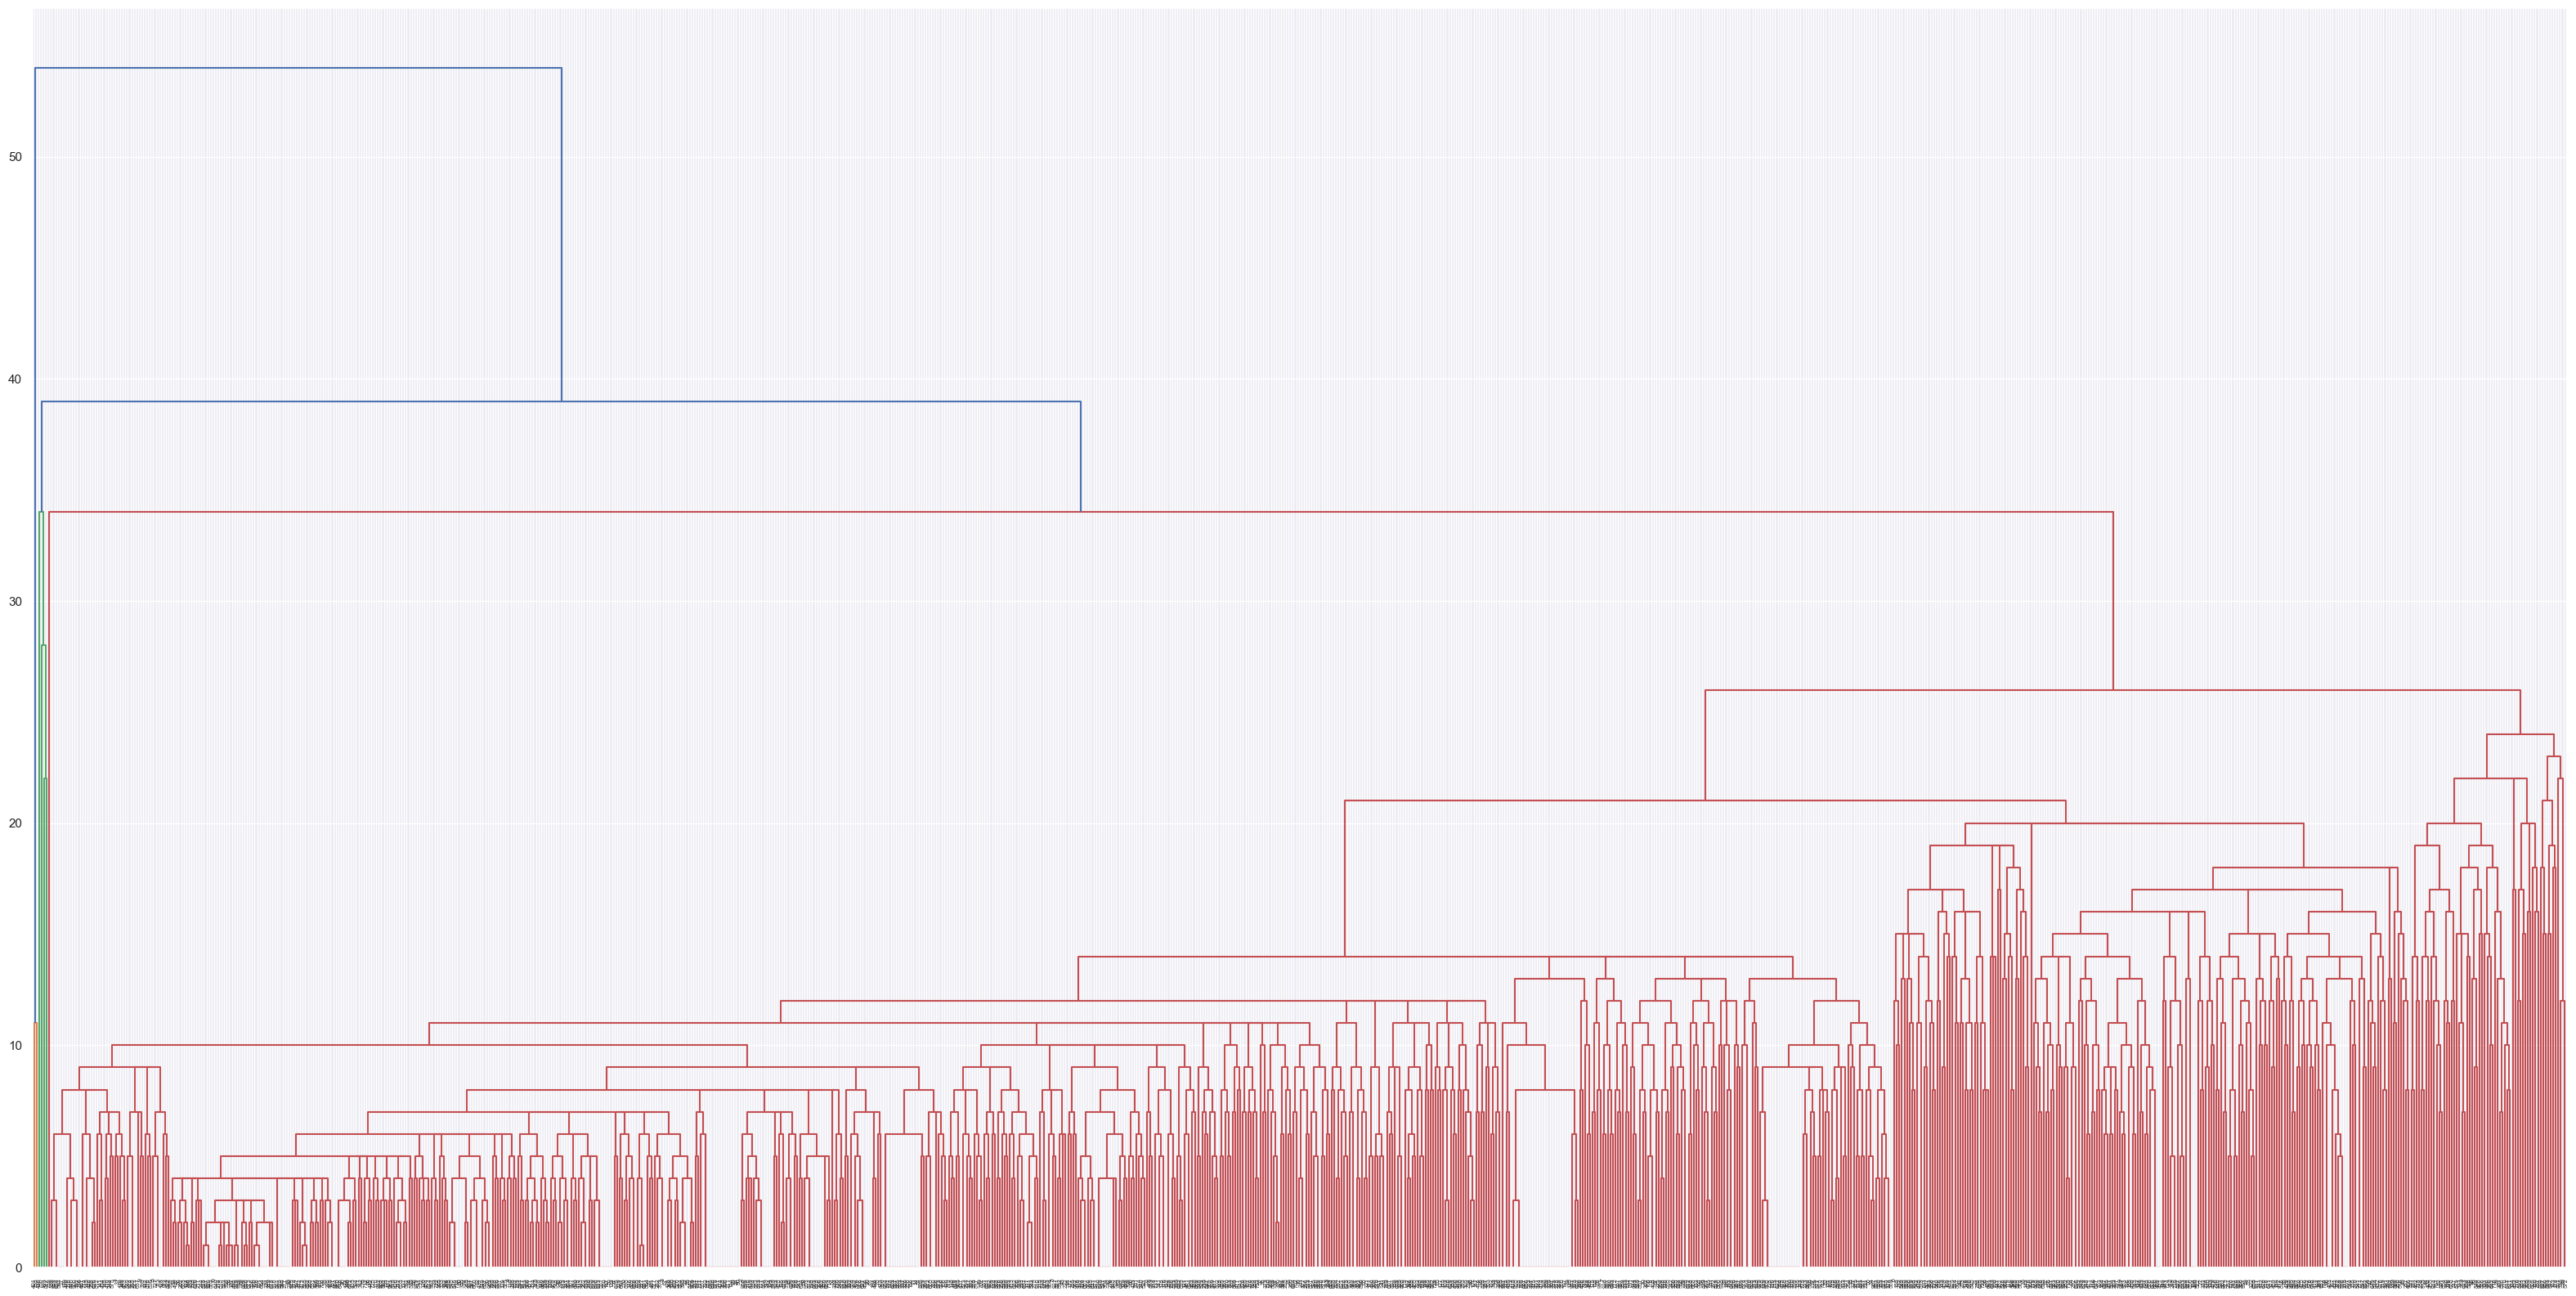

In [117]:
# Perform hierarchical clustering
Z = linkage(distances, "complete")

# Draw dendrogram for visual cutoff selection
fig, ax = plt.subplots(figsize=(40, 20))
dendrogram(Z, ax=ax)


fig1 = fig
plt.show()

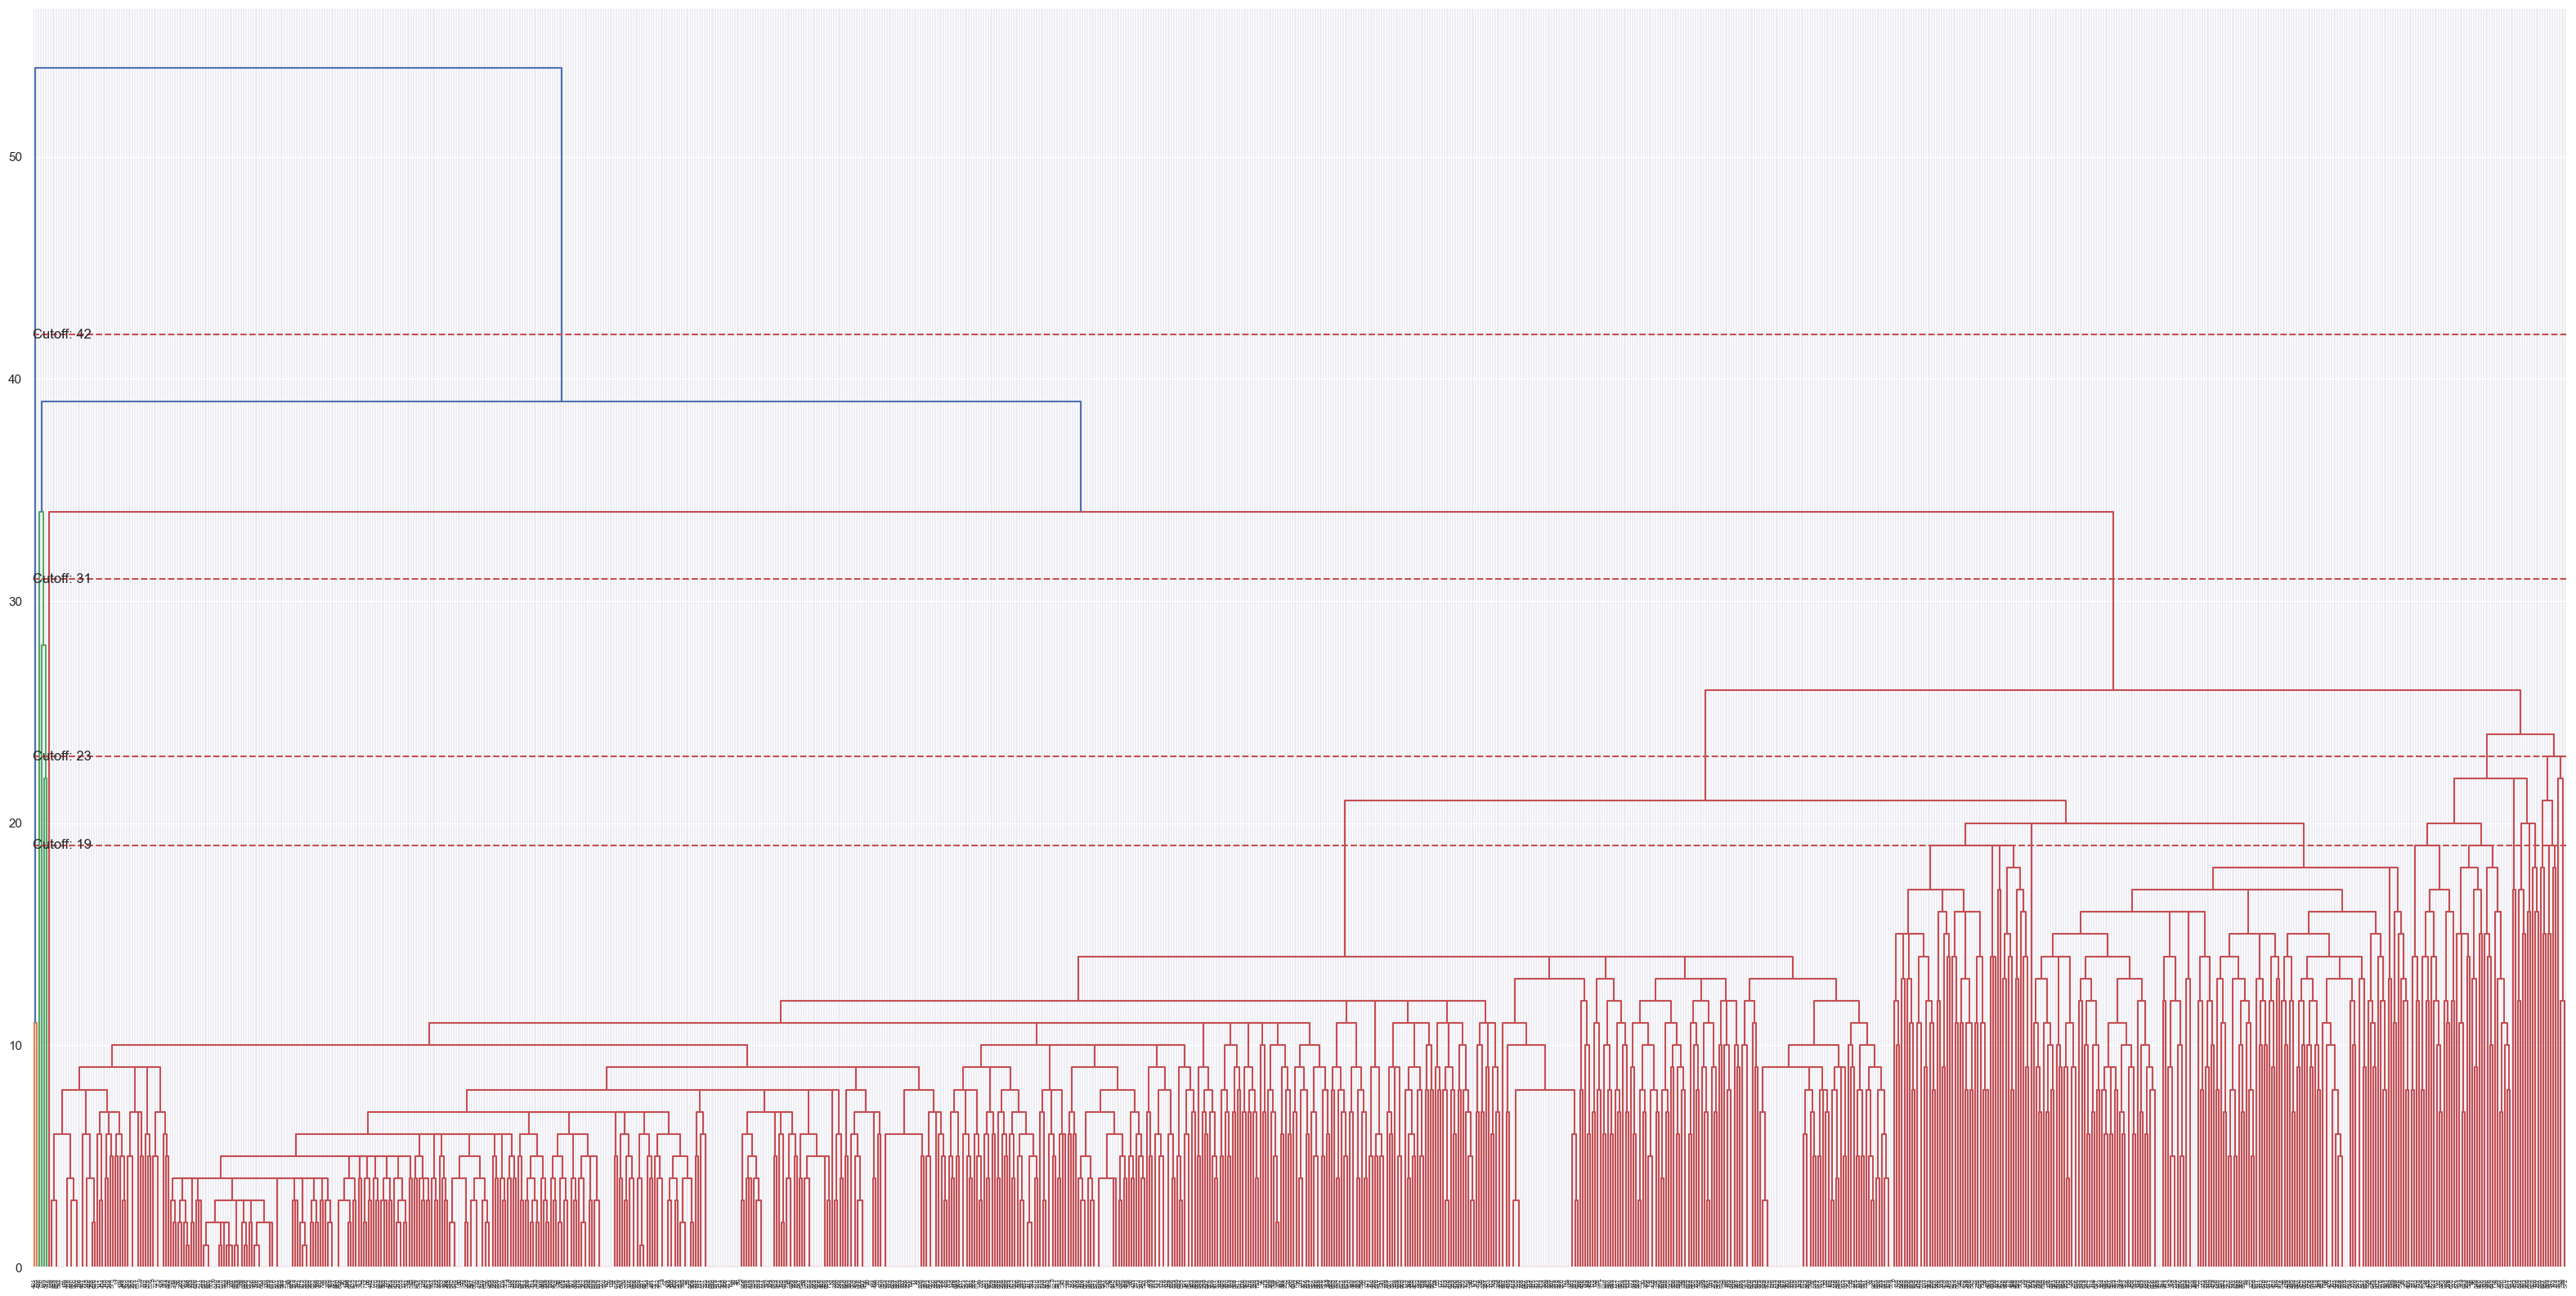

In [118]:
CUTOFF = [42, 23, 19, 31]

# Load the figure object from the previous cell
fig = fig1

# Get the axes object from the figure
ax = fig.axes[0]

# Add the cutoff horizontal line
for cutoff in CUTOFF:
    ax.axhline(y=cutoff, color="r", linestyle="--")
    ax.text(x=ax.get_xlim()[0], y=cutoff, s=f"Cutoff: {cutoff}", va="center")


# Show the plot
fig

In [119]:
# Determine the optimal number of clusters
max_d = 15  # set the threshold distance
clusters = fcluster(Z, max_d, criterion="distance")

In [120]:
# Add cluster labels to the original dataset
urls_tsdf["cluster"] = clusters

#### Evaluation of cluster quality based on cutoff

In [121]:
from sklearn.metrics import silhouette_score

# Compute the silhouette score
silhouette_avg = silhouette_score(
    distances_squareform, urls_tsdf["cluster"], metric="precomputed"
)
print(f"Silhouette score: {silhouette_avg}")

# calculate prevalence of malicious domains in each cluster
cluster_prevalence = urls_tsdf.groupby("cluster")["malicious"].mean()

# group by cluster id and count the number of items in each cluster
cluster_counts = urls_tsdf.groupby("cluster").count()["url"]

# create a dataframe combining the cluster counts and cluster prevalence
cluster_data = pd.DataFrame({"count": cluster_counts, "prevalence": cluster_prevalence})

# filter perfect clusters
non_trivial_clusters = cluster_data.loc[
    (cluster_data["prevalence"] != 0) & (cluster_data["prevalence"] != 1)
]

print(f"Total count of samples {len(urls_tsdf)}")
print(f"Total count of clusters {len(cluster_data)}")
print(
    f"Count of samples in perfect clusters {len(urls_tsdf) - non_trivial_clusters['count'].sum()}"
)

print(
    f"Prevalence of non-perfect malicious domains within clusters:\n{non_trivial_clusters}"
)

Silhouette score: 0.1795420034944597
Total count of samples 1000
Total count of clusters 58
Count of samples in perfect clusters 55
Prevalence of non-perfect malicious domains within clusters:
         count  prevalence
cluster                   
6          727    0.295736
7           17    0.294118
10           3    0.666667
11           6    0.500000
12           6    0.666667
13           3    0.333333
18           3    0.333333
20          51    0.313725
21           9    0.222222
23           7    0.142857
24          26    0.384615
25          34    0.323529
26           8    0.625000
29           5    0.400000
31           4    0.750000
32           4    0.500000
33           5    0.200000
36           6    0.166667
37           3    0.666667
38           2    0.500000
39           4    0.250000
40           6    0.166667
44           2    0.500000
51           2    0.500000
53           2    0.500000


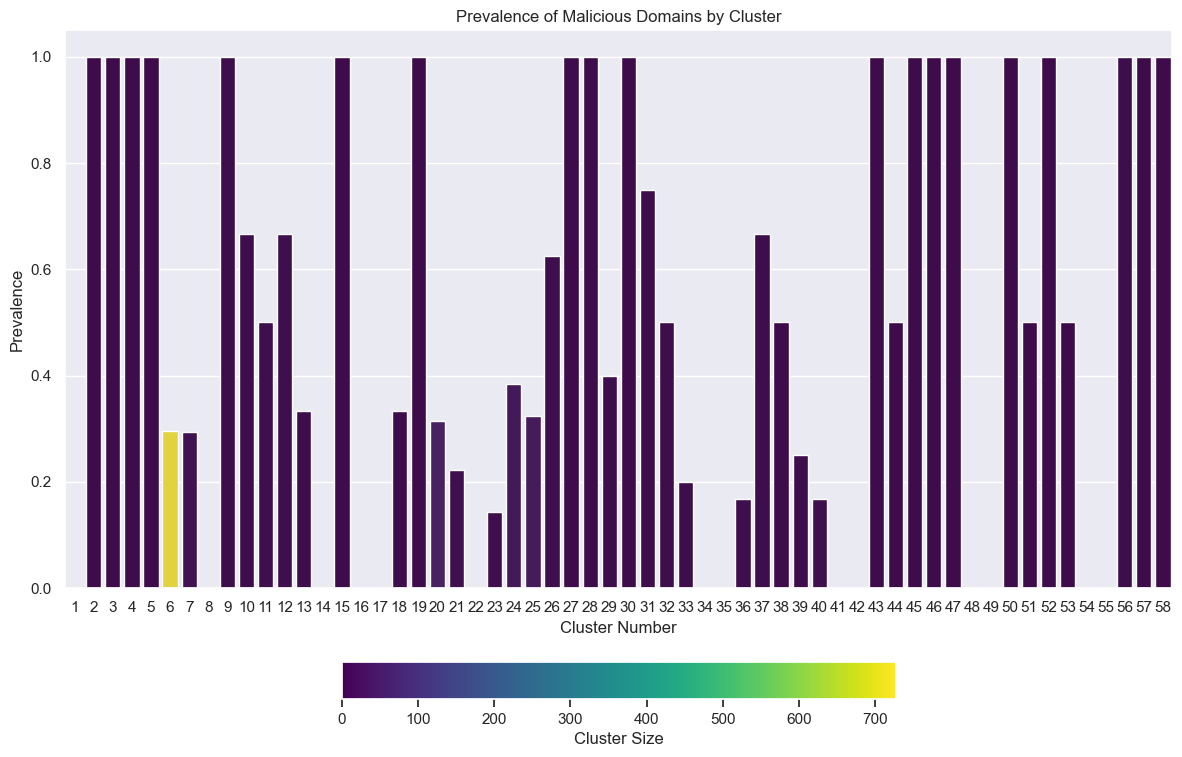

In [122]:
# reset the index to get the cluster id as a column
cluster_data = cluster_data.reset_index()

# Create color palette
colors = sns.color_palette("viridis", as_cmap=True)

# Create bar plot
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(
    x="cluster",
    y="prevalence",
    data=cluster_data,
    palette=colors(cluster_data["count"] / cluster_data["count"].max()),
    ax=ax,
    dodge=False,
)

# Set labels and title
ax.set_title("Prevalence of Malicious Domains by Cluster")
ax.set_xlabel("Cluster Number")
ax.set_ylabel("Prevalence")

# Move the legend outside the plot and make it a gradient line
sm = plt.cm.ScalarMappable(
    cmap=colors, norm=plt.Normalize(vmin=0, vmax=cluster_data["count"].max())
)
sm.set_array([])
cbar = plt.colorbar(
    sm,
    orientation="horizontal",
    pad=0.1,
    shrink=0.5,
    aspect=15,
)
cbar.ax.set_xlabel("Cluster Size")

plt.subplots_adjust(right=0.8)

plt.tight_layout()

plt.show()

In [123]:
urls_tsdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   url                              1000 non-null   string 
 1   type                             1000 non-null   object 
 2   FQDN                             1000 non-null   string 
 3   has_www                          1000 non-null   bool   
 4   subdomain                        1000 non-null   object 
 5   domain                           1000 non-null   object 
 6   TLD                              1000 non-null   object 
 7   is_invalid_TLD                   1000 non-null   bool   
 8   domain_length                    1000 non-null   int64  
 9   subdomain_length                 1000 non-null   int64  
 10  TLD_length                       1000 non-null   int64  
 11  num_of_subdomains                1000 non-null   int64  
 12  domain_alpha_count   

In [124]:
urls_tsdf.groupby("cluster").count()

,url,type,FQDN,has_www,subdomain,domain,TLD,is_invalid_TLD,domain_length,subdomain_length,...,TLD_numeric_count,TLD_special_count,TLD_vowel_consonant_ratio,domain_complexity,subdomain_complexity,benign,defacement,malware,phishing,malicious
cluster,,,,,,,,,,,,,,,,,,,,,
1,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,0,2,2,2,2,2
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
6,727,727,727,727,727,727,727,727,727,727,...,727,727,727,727,322,727,727,727,727,727
7,17,17,17,17,17,17,17,17,17,17,...,17,17,17,17,5,17,17,17,17,17
8,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,0,2,2,2,2,2
9,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,3,4,4,4,4,4
